In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [12]:
def stochastic_update_Adam(w, grad_w, mt, vt,lrate, iteration):
    beta1 = 0.9;
    beta2 = 0.999;
    epsilon = 1e-8;

    mt = mt*beta1 + (1.0-beta1)*grad_w;
    vt = vt*beta2 + (1.0-beta2)*grad_w**2;

    mt_hat = mt/(1.0-beta1**iteration);
    vt_hat = vt/(1.0-beta2**iteration);

    scal = 1.0/(np.sqrt(vt_hat) + epsilon);

    w = w - lrate*mt_hat*scal;
    
    return w, mt, vt

In [13]:
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return np.random.normal(size = [in_dim, out_dim], scale=xavier_stddev)

def initialize_NN(layers):
    weights = []
    biases = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = xavier_init(size=[layers[l], layers[l+1]])
        b = np.zeros([1,layers[l+1]]) 
        weights.append(W)
        biases.append(b)
    return weights, biases

In [14]:
class NN:
    # Initialize the class
    def __init__(self, X, Y, layers):
        
        # data
        self.X = X # N x P
        self.Y = Y # N x Q
        
        # layers
        self.layers = layers # P ----> Q
        
        # initialize NN
        self.weights, self.biases = initialize_NN(layers)

        # Logger
        self.loss_log = []
    
    def loss_function(self):
        num_layers = len(self.layers)
        weights = self.weights
        biases = self.biases
        
        H = [None]*(num_layers-1)
        A = [None]*(num_layers-1)
        
        H[0] = self.X
        A[0] = self.X
        
        for l in range(0,num_layers-2):
            H[l+1] = np.dot(A[l],weights[l]) + biases[l]
            A[l+1] = np.tanh(H[l+1])
        
        Y_pred = np.dot(A[num_layers-2],weights[num_layers-2]) + \
                 biases[num_layers-2]
        
        loss = 0.5*np.sum((Y_pred-self.Y)**2)
        
        ### backpropagation
        
        G = [None]*(num_layers-1)
        loss_weights = [None]*(num_layers-1)
        loss_biases = [None]*(num_layers-1)
        
        G[num_layers-2] = Y_pred - self.Y
        
        for l in range(num_layers-2,0,-1):
            
            loss_weights[l] = np.dot(H[l].T, G[l])
            loss_biases[l] = np.sum(G[l],axis=0)
            
            G[l-1] = (1 - A[l]**2)*np.dot(G[l],weights[l].T)
        
        loss_weights[0] = np.dot(H[0].T, G[0])
        loss_biases[0] = np.sum(G[0],axis=0)
        
        return loss, loss_weights, loss_biases, Y_pred
    
    def train(self, max_iter, learning_rate):
        
        num_layers = len(self.layers)
        
        # Adam Optimizer Parameters        
        mt_weights, mt_biases = [None]*(num_layers-1), [None]*(num_layers-1)
        vt_weights, vt_biases = [None]*(num_layers-1), [None]*(num_layers-1)
        
        for l in range(0,num_layers-1):
            mt_weights[l], mt_biases[l] = [np.zeros(self.weights[l].shape),
                                          np.zeros(self.biases[l].shape)]
            vt_weights[l], vt_biases[l] = [np.zeros(self.weights[l].shape),
                                           np.zeros(self.biases[l].shape)]
        
        for it in trange(1,max_iter+1):
            # Compute loss and gradients 
            loss, loss_weights, loss_biases, Y_pred = self.loss_function()
            
            # Update parameters
            for l in range(0,num_layers-1):
                [self.weights[l],
                 mt_weights[l],
                 vt_weights[l]] = stochastic_update_Adam(self.weights[l],
                                                         loss_weights[l],
                                                         mt_weights[l],
                                                         vt_weights[l],
                                                         learning_rate, it)
                
                [self.biases[l],
                 mt_biases[l],
                 vt_biases[l]] = stochastic_update_Adam(self.biases[l],
                                                        loss_biases[l],
                                                        mt_biases[l],
                                                        vt_biases[l],
                                                        learning_rate, it)
                
            if it % 10 == 0:
                self.loss_log.append(loss)
    
    def test(self,X_star):
        num_layers = len(self.layers)
        weights = self.weights
        biases = self.biases
        
        H = X_star
        A = X_star
        
        for l in range(0,num_layers-2):
            H = np.dot(A,weights[l]) + biases[l]
            A = np.tanh(H)
        
        Y_pred = np.dot(A,weights[num_layers-2]) + biases[num_layers-2]
        
        return Y_pred

100%|██████████| 10000/10000 [00:11<00:00, 843.68it/s]


Error 2.002772e-03


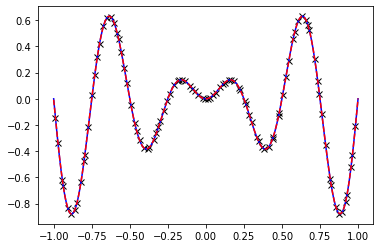

In [15]:
if __name__ == "__main__": 
    
    training_data = np.loadtxt("training_data.csv")
        
    X_train = training_data[:,0:1]
    Y_train = training_data[:,1:2]
    
    model = NN(X_train, Y_train, layers=[1]+10*[10]+[1])
    
    model.train(max_iter=10000, learning_rate=1e-3)
    model.train(max_iter=10000, learning_rate=1e-4)
    model.train(max_iter=10000, learning_rate=1e-5)
    model.train(max_iter=10000, learning_rate=1e-6)

    test_data = np.loadtxt("test_data.csv")
    
    X_test = test_data[:,0:1]
    Y_test = test_data[:,1:2]

    plt.figure()
    plt.plot(X_train,Y_train,'kx')
    plt.plot(X_test,Y_test,'b-')
        
    Y_pred = model.test(X_test)
    
    error = np.linalg.norm(Y_pred - Y_test)/np.linalg.norm(Y_test)
    print('Error %e' %(error))
    
    plt.plot(X_test,Y_pred,'r--')